Let's first get the content of the page that has the ACTUAL form. Which is: http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247 This form is loaded on the actual page using AJAX - which we will not be using at all.

In [1]:
import scipy.stats as stats
from bs4 import BeautifulSoup
import requests
import pandas as pd
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
resp = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247')
resp.status_code

200

Good Resource for Beautiful soup: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
### Getting available parameters from the form
We will need them later. Let's extract them from the HTML using beautifulsoup.

In [3]:
from bs4 import BeautifulSoup
from pprint import pprint as pp
intro_page_soup = BeautifulSoup(resp.text, 'html.parser')

# We examined the html page that includes the form by doing some requests and inspecting the query
# Parameters using Postman and google chrome's debugger, and we realized that we only need 
# ww_x_PERIODE_ACAD, ww_x_PERIODE_PEDAGO


year_options_soups = intro_page_soup.find('select', {'name': 'ww_x_PERIODE_ACAD'}).find_all('option')
year_options = [
    (option['value'], int(option.text.split('-')[0])) for option in year_options_soups if option.text
]

semester_options_soups = intro_page_soup.find('select', {'name': 'ww_x_PERIODE_PEDAGO'}).find_all('option')
semester_options = [
    (option['value'], option.text) for option in semester_options_soups if option.text
]

print("Year Options:")
pp(year_options)

print("Semester Options:")
pp(semester_options)

Year Options:
[('355925344', 2016),
 ('213638028', 2015),
 ('213637922', 2014),
 ('213637754', 2013),
 ('123456101', 2012),
 ('123455150', 2011),
 ('39486325', 2010),
 ('978195', 2009),
 ('978187', 2008),
 ('978181', 2007)]
Semester Options:
[('249108', 'Bachelor semestre 1'),
 ('249114', 'Bachelor semestre 2'),
 ('942155', 'Bachelor semestre 3'),
 ('942163', 'Bachelor semestre 4'),
 ('942120', 'Bachelor semestre 5'),
 ('2226768', 'Bachelor semestre 5b'),
 ('942175', 'Bachelor semestre 6'),
 ('2226785', 'Bachelor semestre 6b'),
 ('2230106', 'Master semestre 1'),
 ('942192', 'Master semestre 2'),
 ('2230128', 'Master semestre 3'),
 ('2230140', 'Master semestre 4'),
 ('2335667', 'Mineur semestre 1'),
 ('2335676', 'Mineur semestre 2'),
 ('2063602308', 'Mise à niveau'),
 ('249127', 'Projet Master automne'),
 ('3781783', 'Projet Master printemps'),
 ('953159', 'Semestre automne'),
 ('2754553', 'Semestre printemps'),
 ('953137', 'Stage automne 3ème année'),
 ('2226616', 'Stage automne 4ème a

In [4]:

base_payload = {
    'ww_x_GPS': -1,
    'ww_i_reportModel': 133685247,
    'ww_i_reportModelXsl': 133685270,
    'ww_x_UNITE_ACAD': 249847, #ID of Informatique Department
    'ww_x_PERIODE_ACAD': 213637754, # we will change this (Using YEARS options)
    'ww_x_PERIODE_PEDAGO': 249108, #we will change this (Using SEMESTERS options)
    'ww_x_HIVERETE': 'null' #? well this was there - better not touch - works fine like this..
}

### Exercise 1: Bachelor Students

In [5]:
import pandas as pd
import concurrent.futures
import itertools


bachelors_final_table = None

def grab_table(semester_tuple, year_tuple):
    year_value,year_int = year_tuple
    semester_value, semester_col = semester_tuple
    payload = dict(base_payload)
    payload['ww_x_PERIODE_ACAD'] = year_value
    payload['ww_x_PERIODE_PEDAGO'] = semester_value 
    resp = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html', params = payload)
    try:
        table = pd.read_html(resp.text, header=1)[0][['Civilité', 'Nom Prénom', 'Statut', 'No Sciper', 'Spécialisation']]
    except:
        return None
    table[semester_col] = year_int
    table['No Sciper'] = table['No Sciper'].astype(str)
    table.set_index(['No Sciper'], inplace=True, drop=False)
    print(semester_col, year_int,"done")
    return table
    
semester_tuples = [('249108', 'Semester 1'), ('942120', 'Semester 5'),('942175', 'Semester 6')]
year_tuples = year_options

#frames = map(lambda x: grab_table(*x), itertools.product(semester_tuples, year_tuples))
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    frames = executor.map(lambda x: grab_table(*x), itertools.product(semester_tuples, year_tuples))
    
print("Finished")
frames = filter(lambda x : x is not None, frames)
for frame in frames:
    if bachelors_final_table is None:
        bachelors_final_table = frame
    else:
        bachelors_final_table = pd.merge(frame, bachelors_final_table, how='outer')

bachelors_final_table.columns

Semester 1 2011 done
Semester 1 2012 done
Semester 1 2007 done
Semester 1 2008 done
Semester 1 2009 done
Semester 1 2013 done
Semester 1 2010 done
Semester 1 2014 done
Semester 1 2016 done
Semester 5 2016 done
Semester 1 2015 done
Semester 5 2015 done
Semester 5 2012 done
Semester 5 2013 done
Semester 5 2011 done
Semester 5 2010 done
Semester 6 2016 done
Semester 5 2007 done
Semester 5 2008 done
Semester 5 2009 done
Semester 5 2014 done
Semester 6 2014 done
Semester 6 2010 done
Semester 6 2012 done
Semester 6 2008 done
Semester 6 2011 done
Semester 6 2007 done
Semester 6 2009 done
Semester 6 2015 done
Semester 6 2013 done
Finished


Index(['Civilité', 'Nom Prénom', 'Statut', 'No Sciper', 'Spécialisation',
       'Semester 6', 'Semester 5', 'Semester 1'],
      dtype='object')

In [6]:
def get_merged_(group):
    #Drop the groups (enrollment record of a single person) which doesn't include Semester 6 and Semester 1
    if len(group) > 1 and len(group.dropna(subset=['Semester 6'])) > 0 and len(group.dropna(subset=['Semester 1'])) > 0:
        ending = max(group[['Semester 6']].max(axis=0))
        starting = min(group[['Semester 1']].min(axis=0))
        
        semester_5_year = max(group[['Semester 5']].max(axis=0))
        
        extra = 6 if semester_5_year > ending else 0 
            
        #semester_5_year = max(group[['Semester 1','Semester 5','Semester 6']].max(axis=0))
        
        return pd.DataFrame({
            "No Sciper": group.iloc[0]['No Sciper'],
            "duration": (ending-starting+1)*12 + extra, #months
            "gender": group.iloc[0]['Civilité']
        }, index=['No Sciper'])
    return pd.DataFrame([])

grouped = bachelors_final_table.groupby('No Sciper')
filtered = grouped.apply(get_merged_)

print(filtered.head())
print(filtered.describe())

                    No Sciper  duration    gender
No Sciper                                        
147008    No Sciper    147008      36.0  Monsieur
169569    No Sciper    169569      36.0  Monsieur
169731    No Sciper    169731      48.0  Monsieur
169795    No Sciper    169795      54.0  Monsieur
171195    No Sciper    171195      36.0  Monsieur
         duration
count  397.000000
mean    42.725441
std      9.372089
min     36.000000
25%     36.000000
50%     36.000000
75%     48.000000
max     84.000000


In [7]:
filtered.groupby('gender').apply(lambda x: x.describe())


duration
gender                    
Madame   count   29.000000
         mean    40.758621
         std      8.078433
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     66.000000
Monsieur count  368.000000
         mean    42.880435
         std      9.458750
         min     36.000000
         25%     36.000000
         50%     36.000000
         75%     48.000000
         max     84.000000

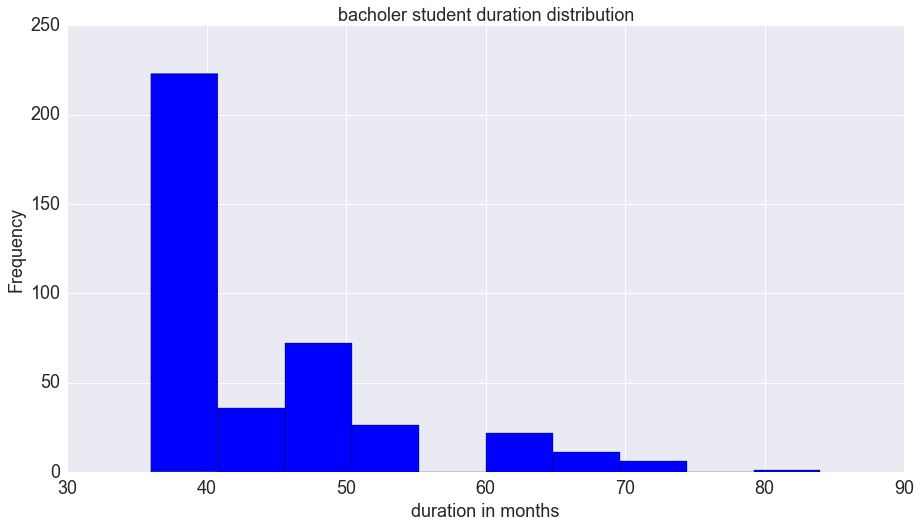

In [8]:
filtered.hist(column='duration', figsize=(15,8), color = 'blue')
plt.title('bacholer student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [9]:
madames_durations = filtered[filtered['gender'] == 'Madame']['duration']
monsieur_durations = filtered[filtered['gender'] == 'Monsieur']['duration']

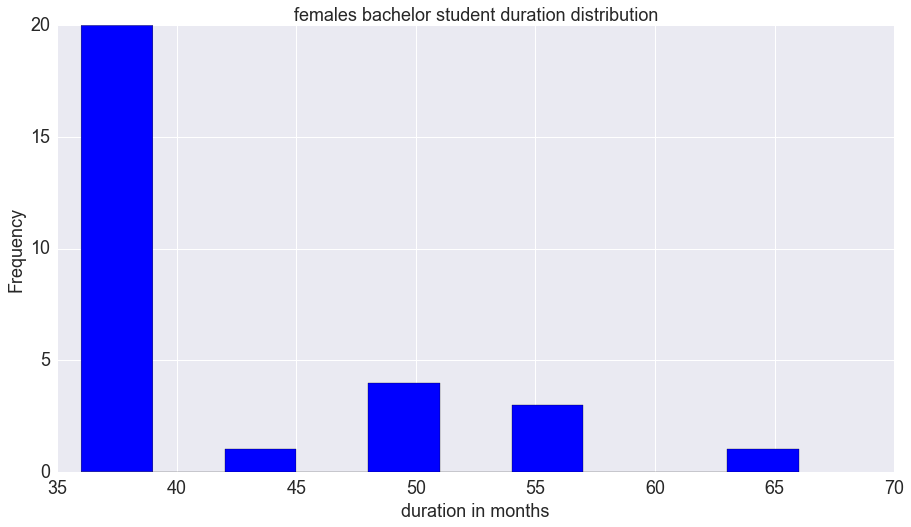

In [10]:
madames_durations.hist(figsize=(15,8), color = 'blue')
plt.title('females bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

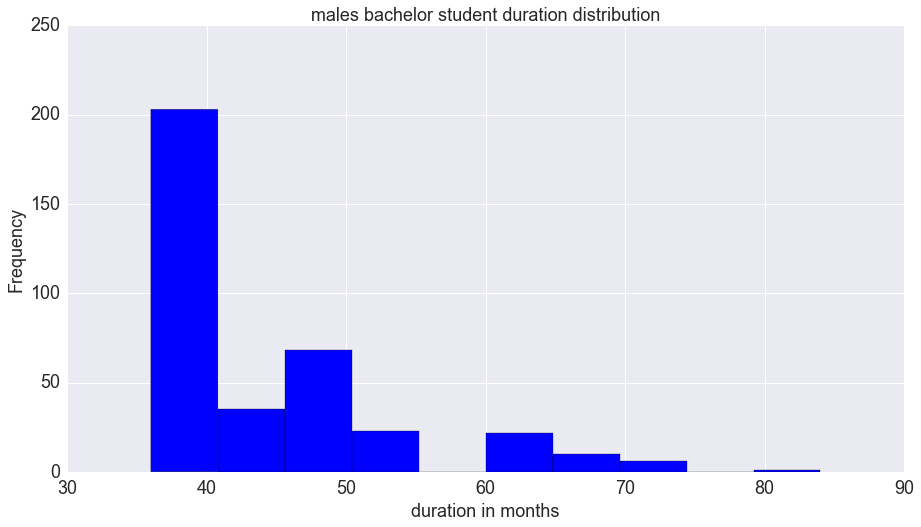

In [11]:
monsieur_durations.hist(figsize=(15,8), color = 'blue')
plt.title('males bachelor student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

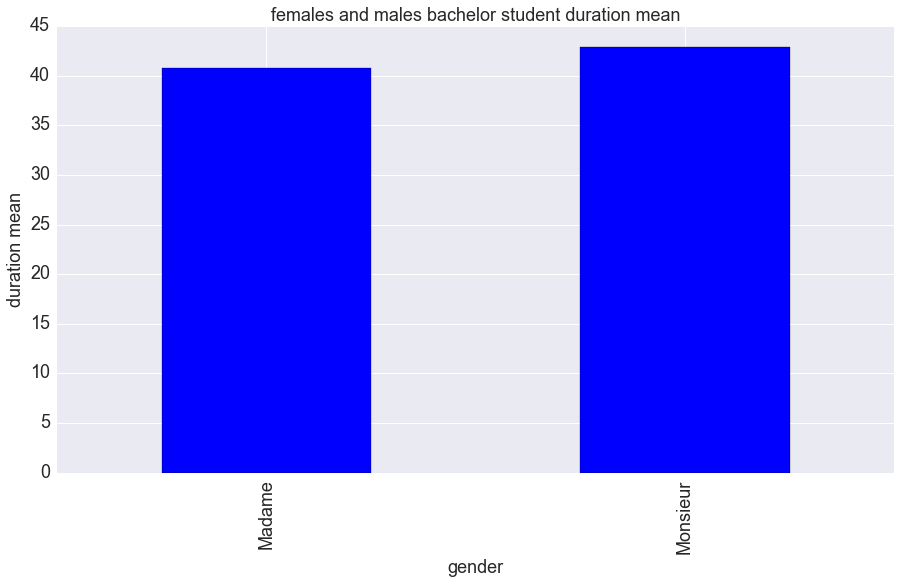

In [12]:
filtered.groupby('gender').duration.mean().plot(kind='bar', color='blue',figsize=(15,8))
plt.title('females and males bachelor student duration mean', fontsize=18)
plt.xlabel('gender', fontsize=18)
plt.ylabel('duration mean', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [13]:
import scipy
import scipy.stats as stats

stats.ttest_ind(madames_durations, monsieur_durations)

Ttest_indResult(statistic=-1.174373961635091, pvalue=0.2409527870885366)

### Exercise 2: Masters Students

In [14]:

master_semesters = [
    ('2230106', 'Master semestre 1'),
    ('942192', 'Master semestre 2'),
    ('2230128', 'Master semestre 3'),
    ('2230140', 'Master semestre 4'),
    ('249127', 'Projet Master automne'),
    ('3781783', 'Projet Master printemps'),
]

masters_final_table = None

#frames = map(lambda x: grab_table(*x), itertools.product(master_semesters, year_tuples))
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    master_frames = executor.map(lambda x: grab_table(*x), itertools.product(master_semesters, year_tuples))
print("Finished")
master_frames = filter(lambda x : x is not None, master_frames)
for frame in master_frames:
    if masters_final_table is None:
        masters_final_table = frame
    else:
        #bachelors_final_table = pd.merge(table[['No Sciper', semester_col]], bachelors_final_table, left_on='No Sciper', right_on='No Sciper', how='outer')
        masters_final_table = pd.merge(frame, masters_final_table, how='outer')

masters_final_table.columns

Master semestre 1 2009 done
Master semestre 1 2007 done
Master semestre 2 2016 done
Master semestre 1 2008 done
Master semestre 1 2010 done
Master semestre 1 2012 done
Master semestre 1 2014 done
Master semestre 1 2011 done
Master semestre 1 2013 done
Master semestre 1 2016 done
Master semestre 1 2015 done
Master semestre 2 2015 done
Master semestre 2 2014 done
Master semestre 2 2012 done
Master semestre 2 2009 done
Master semestre 2 2008 done
Master semestre 2 2007 done
Master semestre 2 2013 done
Master semestre 3 2015 done
Master semestre 3 2014 done
Master semestre 2 2011 done
Master semestre 2 2010 done
Master semestre 3 2009 done
Master semestre 3 2010 done
Master semestre 3 2012 done
Master semestre 3 2011 done
Master semestre 3 2008 done
Master semestre 3 2007 done
Master semestre 3 2013 done
Master semestre 3 2016 done
Projet Master automne 2015 done
Projet Master automne 2012 done
Projet Master automne 2011 done
Projet Master automne 2014 done
Projet Master automne 2013 done


Index(['Civilité', 'Nom Prénom', 'Statut', 'No Sciper', 'Spécialisation',
       'Projet Master printemps', 'Projet Master automne', 'Master semestre 3',
       'Master semestre 2', 'Master semestre 1'],
      dtype='object')

In [15]:
from pprint import pprint as pp

def masters_get_merged_(group):
    
    
    # To not count the students that only have entries in 'Project', we first temporarly have the table with MA1, MA2 and MA3
    # columns
    ma1_ma2_ma3 = group[['No Sciper', 'Master semestre 1', 'Master semestre 2', 'Master semestre 3']]
    ma1_ma2_ma3 = ma1_ma2_ma3.dropna(subset=['Master semestre 1', 'Master semestre 2', 'Master semestre 3'], how='all')
    project_entries = group[['No Sciper','Projet Master printemps', 'Projet Master automne']]
    project_entries = project_entries.dropna(subset=['Projet Master printemps', 'Projet Master automne'], how='all')
    project_entries = project_entries.drop_duplicates(subset=['Projet Master printemps', 'Projet Master automne'])
    spec_table = group[['Spécialisation']].dropna(subset=['Spécialisation'])
    
    if len(spec_table) > 0:
        spec = spec_table.iloc[-1]['Spécialisation']
    else:
        spec = None
    
    
    #Drop the groups (enrollment record of a single person) which doesn't include Master Semester 1
    if len(group.dropna(subset=['Master semestre 1'])) > 0 and len(ma1_ma2_ma3) > 1:
        
        #ending = max(group[['Master semestre 2','Master semestre 3','Projet Master automne', 'Projet Master printemps']].max(axis=0))
        
        starting = min(group[['Master semestre 1', 'Master semestre 2']].min(axis=0))
        
        duration = len(ma1_ma2_ma3)
        
        project_time = max(6,len(project_entries)*6)
        #pp(ma1_ma2_ma3)
        #print(starting,ending)
        #return group
        
        ma1_ma2_ma3 = ma1_ma2_ma3.dropna(subset=['Master semestre 1', 'Master semestre 2', 'Master semestre 3'], how='all')
        
        return pd.DataFrame({
            "No Sciper": group.iloc[0]['No Sciper'],
            "duration": duration*6,
            'project_time': project_time,
            'start_year': starting,
            'total_duration': project_time+duration*6,
            "gender": group.iloc[0]['Civilité'],
            'specialization': spec
        }, index=['No Sciper'])
    return pd.DataFrame([])

masters_grouped = masters_final_table.groupby('No Sciper')
masters_filtered = masters_grouped.apply(masters_get_merged_)

masters_filtered.describe()

## TODOO...

#138088
#masters_final_table[masters_final_table['No Sciper'] == '146742']
masters_filtered.head()
#masters_filtered[masters_filtered['project_time'] == 12]

,,No Sciper,duration,gender,project_time,specialization,start_year,total_duration
No Sciper,,,,,,,,
146330,No Sciper,146330,18.0,Monsieur,6.0,None,2007.0,24.0
146742,No Sciper,146742,30.0,Monsieur,12.0,"Signals, Images and Interfaces",2008.0,42.0
146929,No Sciper,146929,12.0,Monsieur,6.0,None,2007.0,18.0
147008,No Sciper,147008,24.0,Monsieur,6.0,"Signals, Images and Interfaces",2011.0,30.0
152232,No Sciper,152232,18.0,Monsieur,6.0,None,2007.0,24.0


In [16]:
aa=masters_filtered

In [17]:
len(aa)

764

In [18]:
aa['specialization'].unique()

array([None, 'Signals, Images and Interfaces', 'Internet computing',
       'Biocomputing', 'Foundations of Software',
       'Computer Engineering - SP', 'Service science', 'Software Systems',
       'Information Security - SP', 'Data Analytics',
       'Internet Information Systems', 'Computer Science Theory'], dtype=object)

In [19]:
df_Signals=aa[aa['specialization']=='Signals, Images and Interfaces']
df_Internetcomputing=aa[aa['specialization']=='Internet computing']
df_Biocomputing=aa[aa['specialization']=='Biocomputing']
df_FoundationsofSoftware=aa[aa['specialization']=='Foundations of Software']
df_ComputerEngineering=aa[aa['specialization']=='Computer Engineering - SP']
df_Servicescience=aa[aa['specialization']=='Service science']
df_SoftwareSystems=aa[aa['specialization']=='Software Systems']
df_InformationSecurity=aa[aa['specialization']=='Information Security - SP']
df_DataAnalytics=aa[aa['specialization']=='Data Analytics']
df_InternetInformationSystems=aa[aa['specialization']=='Internet Information Systems']
df_ComputerScienceTheory=aa[aa['specialization']=='Computer Science Theory']

In [20]:
general_dur = aa['total_duration']
df_Signals_dur = df_Signals['total_duration']
df_Internetcomputing_dur = df_Internetcomputing['total_duration']
df_Biocomputing_dur = df_Biocomputing['total_duration']
df_FoundationsofSoftware_dur = df_FoundationsofSoftware['total_duration']
df_ComputerEngineering_dur = df_ComputerEngineering['total_duration']
df_Servicescience_dur = df_Servicescience['total_duration']
df_SoftwareSystems_dur = df_SoftwareSystems['total_duration']
df_InformationSecurity_dur = df_InformationSecurity['total_duration']
df_DataAnalytics_dur = df_DataAnalytics['total_duration']
df_InternetInformationSystems_dur = df_InternetInformationSystems['total_duration']
df_ComputerScienceTheory_dur = df_ComputerScienceTheory['total_duration']

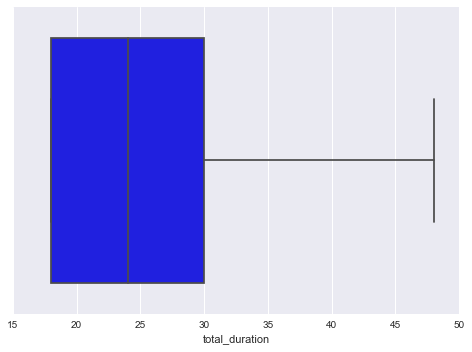

In [21]:
sns.boxplot(aa.total_duration, showfliers=False, color = 'blue')


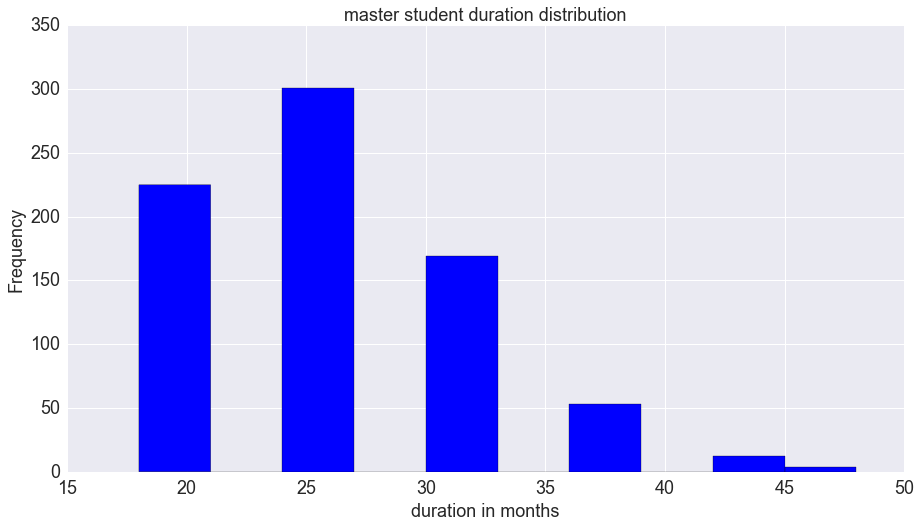

In [22]:
aa.hist(column='total_duration',figsize=(15,8), color = 'blue')
plt.title('master student duration distribution', fontsize=18)
plt.xlabel('duration in months', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)

In [23]:
aa1=aa.reset_index(drop=True)
aa1

,No Sciper,duration,gender,project_time,specialization,start_year,total_duration
0,146330,18.0,Monsieur,6.0,None,2007.0,24.0
1,146742,30.0,Monsieur,12.0,"Signals, Images and Interfaces",2008.0,42.0
2,146929,12.0,Monsieur,6.0,None,2007.0,18.0
3,147008,24.0,Monsieur,6.0,"Signals, Images and Interfaces",2011.0,30.0
4,152232,18.0,Monsieur,6.0,None,2007.0,24.0
5,153066,36.0,Monsieur,6.0,Internet computing,2007.0,42.0
6,153746,18.0,Monsieur,6.0,None,2007.0,24.0
7,153762,24.0,Monsieur,6.0,None,2008.0,30.0
8,154080,30.0,Monsieur,6.0,Internet computing,2007.0,36.0
9,154573,30.0,Madame,6.0,Biocomputing,2007.0,36.0


In [24]:
general_dur.mean()

24.801047120418847

In [25]:
stats.ttest_ind(general_dur, df_Signals_dur)

Ttest_indResult(statistic=-4.2163948214600699, pvalue=2.7680174474771483e-05)

In [26]:
stats.ttest_ind(general_dur, df_Internetcomputing_dur)

Ttest_indResult(statistic=-4.555324209320645, pvalue=5.9934131304556089e-06)

In [27]:
stats.ttest_ind(general_dur, df_Biocomputing_dur)

Ttest_indResult(statistic=-1.7257839794652425, pvalue=0.084789554599280018)

In [28]:
stats.ttest_ind(general_dur, df_FoundationsofSoftware_dur)

Ttest_indResult(statistic=-4.5489075810562758, pvalue=6.2036451290649428e-06)

In [29]:
stats.ttest_ind(general_dur, df_ComputerEngineering_dur)

Ttest_indResult(statistic=-0.7385280910631068, pvalue=0.46041518867225095)

In [30]:
stats.ttest_ind(general_dur, df_Servicescience_dur)

Ttest_indResult(statistic=-1.0393171245617119, pvalue=0.29898478764822378)

In [31]:
stats.ttest_ind(general_dur, df_SoftwareSystems_dur)

Ttest_indResult(statistic=0.30528282176362936, pvalue=0.76023230943792064)

In [32]:
stats.ttest_ind(general_dur, df_InformationSecurity_dur)

Ttest_indResult(statistic=1.4793014650653615, pvalue=0.13946927216856539)

In [33]:
stats.ttest_ind(general_dur, df_DataAnalytics_dur)

Ttest_indResult(statistic=2.0830598126568272, pvalue=0.037576457618531275)

In [34]:
stats.ttest_ind(general_dur, df_InternetInformationSystems_dur)

/Users/Ray/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Ttest_indResult(statistic=nan, pvalue=nan)

In [35]:
stats.ttest_ind(general_dur, df_ComputerScienceTheory_dur)

/Users/Ray/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Ttest_indResult(statistic=nan, pvalue=nan)

### Bonus Excercise ..

In [36]:
female_master_dur = aa1[aa1['gender'] == 'Madame']['total_duration']
male_master_dur = aa1[aa1['gender'] == 'Monsieur']['total_duration']
stats.ttest_ind(female_master_dur, male_master_dur)

Ttest_indResult(statistic=0.48166298285926606, pvalue=0.63018367378934903)

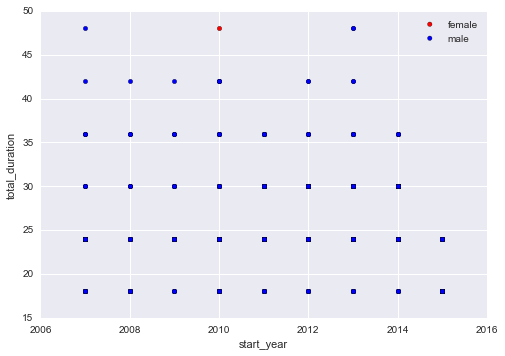

In [37]:
data_female = aa1[aa1['gender'] == 'Madame']
data_male = aa1[aa1['gender'] == 'Monsieur']

ax = data_female.plot(kind='scatter', x='start_year', y='total_duration', color='red', label='female');
data_male.plot(kind='scatter', x='start_year', y='total_duration', color='blue', label='male', ax=ax);

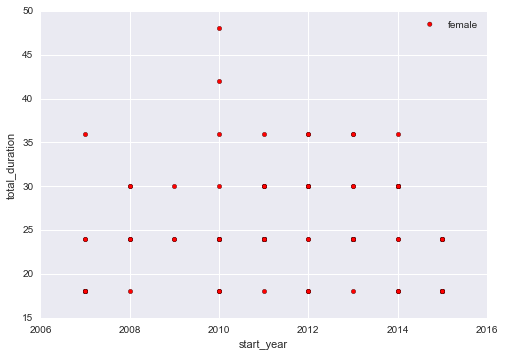

In [38]:
data_female.plot(kind='scatter', x='start_year', y='total_duration', color='red', label='female');

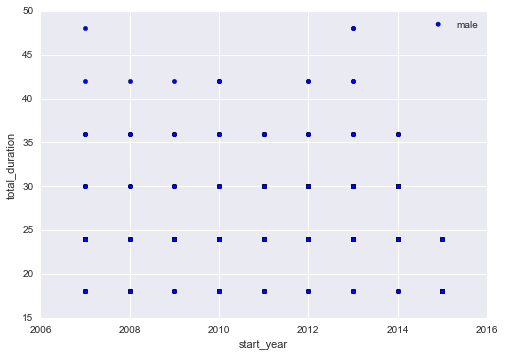

In [39]:
data_male.plot(kind='scatter', x='start_year', y='total_duration', color='blue', label='male')

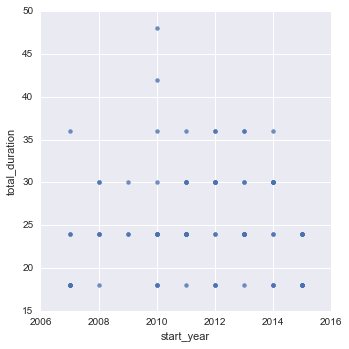

In [40]:
sns.lmplot("start_year", "total_duration", data=data_female, fit_reg=False)

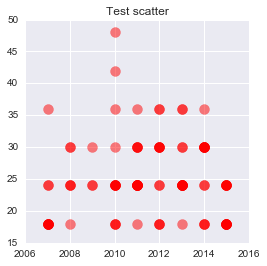

In [41]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="Test scatter")
ax.scatter(data_female['start_year'], data_female['total_duration'], s=100, color="red", alpha=0.5)
#ax.scatter(data_male['start_year'], data_male['total_duration'], s=100, color="red", alpha=0.5)
#fig.savefig("test_scatter.png")


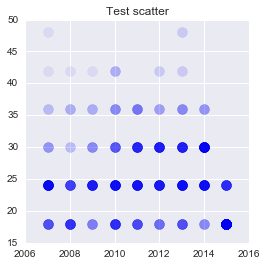

In [42]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="Test scatter")
#ax.scatter(data_female['start_year'], data_female['total_duration'], s=100, color="blue", alpha=0.5)
ax.scatter(data_male['start_year'], data_male['total_duration'], s=100, color="blue", alpha=0.07)
#fig.savefig("test_scatter.png")


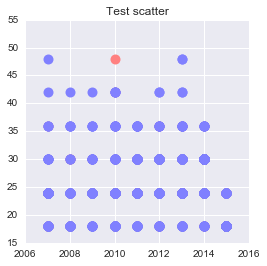

In [43]:
x1=data_female['start_year']
y1=data_female['total_duration']
x2=data_male['start_year']
y2=data_male['total_duration']

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, title="Test scatter")
alpha = 0.5
ax.scatter(x1, y1, s=100, lw = 0, color=[1., alpha, alpha])
ax.scatter(x2, y2, s=100, lw = 0, color=[alpha, alpha, 1.])
plt.show()


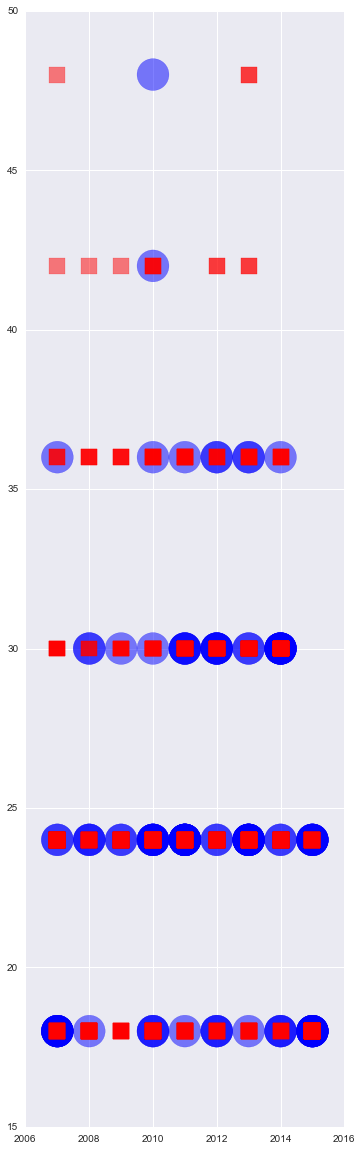

In [50]:
import pylab
import matplotlib

def my_circle_scatter(axes, x_array, y_array, radius=0.5, **kwargs):
    for x, y in zip(x_array, y_array):
        circle = pylab.Circle((x,y), radius=radius, **kwargs)
        axes.add_patch(circle)
    return True

def my_square_scatter(axes, x_array, y_array, size=0.5, **kwargs):
    size = float(size)
    for x, y in zip(x_array, y_array):
        square = pylab.Rectangle((x-size/2,y-size/2), size, size, **kwargs)
        axes.add_patch(square)
    return True

def my_polygon_scatter(axes, x_array, y_array, resolution=5, radius=0.5, **kwargs):
    ''' resolution is number of sides of polygon '''
    for x, y in zip(x_array, y_array):
        polygon = matplotlib.patches.CirclePolygon((x,y), radius=radius, resolution=resolution, **kwargs)
        axes.add_patch(polygon)
    return True


axes=pylab.axes()
my_circle_scatter(axes, x1, y1, radius=.5, alpha=.5, color='b')
my_square_scatter(axes, x2, y2, size=.5, alpha=.5, color='r')
#my_polygon_scatter(axes, [-1,-2,3], [-3,0,3], radius=.5, resolution=3, alpha=.5, color='g')
#my_polygon_scatter(axes, [4,1.5,3], [2,-1,-3], radius=.5, resolution=5, alpha=.5, color='k')
pylab.axis('scaled')
#pylab.axis([2007,2200,0,50])
pylab.rcParams['figure.figsize'] = 15, 20
pylab.show()